In [1]:
from decoder import *
from encoder import *
from textEncoder import *
from genZero import *
from other_data_loader import *
import pickle
import random
import torch.optim as optim
from torch.autograd import Variable
import csv
import time
from tqdm import tqdm
import gc
import os
import torchvision.transforms as tf
import json
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.translate.bleu_score import corpus_bleu
from matplotlib import pyplot as plt


[nltk_data] Downloading package punkt to
[nltk_data]     /datasets/home/64/364/rhadden/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:


def validate(val_loader, encoder, decoder, embed, stack, maxSeqLen,
             vocab, batch_size, use_gpu = True):

    
    #Evaluation Mode
    decoder.eval()
    encoder.eval()
    embed.eval()
    stack.eval()
    lam = 20
    # critereon
    discCrit = nn.BCEWithLogitsLoss()
    textCrit = nn.CrossEntropyLoss()
    distCrit = nn.SmoothL1Loss()
    if use_gpu:
        device = torch.device("cuda:0")
        
        
    with torch.no_grad():
        
        count    = 0
        loss_avg = 0

                
        for i, (inputs, labels, lengths) in enumerate(val_loader):
            
            
            
            # Move to device, if available
            if use_gpu:
                inputs = inputs.to(device)# Move your inputs onto the gpu
                labels = labels.to(device) # Move your labels onto the gpu
                        

            #STEM
            embed.resetHidden(labels.shape[0])
            pred_out, w, s = embed(labels, lengths)
            
            #GLAM
            generated_imgs, h0s, discr_gen, discr_real = stackZero(s, inputs)
            
            
            # STREAM
            enc_out = encoder(generated_imgs)

            decoder.resetHidden(inputs.shape[0])
            outputs = decoder(labels, enc_out, lengths) #calls forward
            
            
            loss = (
                    distCrit(generated_imgs, inputs)
                    + lam*textCrit(outputs, labels.cuda())
                    + discCrit(discr_real, torch.ones(discr_real.shape).cuda())
            )
            
            loss_avg += loss.item()
            count+=1
            
            
            del labels
            del inputs
            del outputs            
            
            

                
        loss_avg  = loss_avg/count



        
        
            
    return loss_avg

In [3]:
def trainStack(encoder, decoder, embed, stackZero, epochs, train_loader,val_loader, test_loader,
                        name, batch_size, maxSeqLen, vocab, disc_gen_split, save_generated_imgs= False):
    
    #Create non-existing logfiles
    logname = './logs/' + name + '.log'
    i = 0
    if os.path.exists(logname) == True:
        
        logname = './logs/' + name + str(i) + '.log'
        while os.path.exists(logname):
            i+=1
            logname = './logs/' + name + str(i) + '.log'

    print('Loading results to logfile: ' + logname)
    with open(logname, "w") as file:
        file.write("Log file DATA: Validation Loss and Accuracy\n") 
    
    logname_summary = './logs/' + name + '_summary' + str(i) + '.log'    
    print('Loading Summary to : ' + logname_summary) 
    
    
    try:
        os.mkdir('./generated_imgs')
    except:
        pass
    
    generated_imgs_filename = './generated_imgs/generated_imgs' + name + '_summary' + str(i) + '.log'
    
    parameters = list(stackZero.parameters())
    optimizer = optim.Adam(parameters, lr=2e-4)
    
    lam = 20
    discCrit = nn.BCEWithLogitsLoss()
    textCrit = nn.CrossEntropyLoss()
    distCrit = nn.SmoothL1Loss()
    
    use_gpu = torch.cuda.is_available()
    if use_gpu:
        device = torch.device("cuda:0")

        encoder.to(device)
        decoder.to(device)
        embed.to(device)
        stackZero.to(device)
    temperature=1
    
    val_loss_set = []

    training_loss = []
    
    # Early Stop criteria
    minLoss = 1e6
    minLossIdx = 0
    earliestStopEpoch = 7
    earlyStopDelta = 3
    for epoch in range(epochs):
        ts = time.time()

        for iter, (inputs, labels, lengths) in tqdm(enumerate(train_loader)):

            optimizer.zero_grad()
            
            stackZero.train()
            encoder.train()
            decoder.train()
            embed.train()
            
            if use_gpu:
                inputs = inputs.to(device)# Move your inputs onto the gpu
                labels = labels.to(device) # Move your labels onto the gpu
            
            
            #For first epoch will train the discriminator/generator everyother iteration
            if epoch ==0:
                #print("0")
                if iter % 5 == 0:
                    # Train discriminator
                    for param in stackZero.parameters():
                        param.requires_grad = False
                        
                    stackZero.setDiscriminatorGrad(True)
                    
                else:
                    # Train generator
                    for param in stackZero.parameters():
                        param.requires_grad = True
                    stackZero.setDiscriminatorGrad(False)
#                     discParameters = list(stackZero.D0_down.parameters())
#                     discParameters.extend(stackZero.D0_join.parameters())
#                     discParameters.extend(stackZero.D0_judge.parameters())
#                     for param in discParameters:
#                         param.requires_grad = False
                    
                    
            # After first epoch will train discriminator every 5 epochs
            elif epoch % 5 == 0:
                
                # Train discriminator
                for param in stackZero.parameters():
                    param.requires_grad = False
                        
                stackZero.setDiscriminatorGrad(True)
                
            else:
                
                # Train generator
                for param in stackZero.parameters():
                    param.requires_grad = True
                        
                stackZero.setDiscriminatorGrad(False)
                
            
            
            
            #STEM
            embed.resetHidden(labels.shape[0])
            pred_out, w, s = embed(labels, lengths)
            
            #GLAM
            generated_imgs, h0s, discr_gen, discr_real = stackZero(s, inputs)
            
            
            # STREAM
            enc_out = encoder(generated_imgs)

            decoder.resetHidden(inputs.shape[0])
            outputs = decoder(labels, enc_out, lengths) #calls forward
            
            #For first epoch will train the discriminator/generator everyother iteration
            if epoch ==0:
                #print("0")
                if iter % 5 == 0:
                    # Train discriminator
                    loss = (
                        discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda()) 
                        + discCrit(discr_real, torch.ones(discr_real.shape).cuda())
                    )
                else:
                    # Train generator
                    loss = (
                        distCrit(generated_imgs, inputs)
                        + lam*textCrit(outputs, labels.cuda())
                        - discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda())
                    )
                    
                    
            # After first epoch will train discriminator every 5 epochs
            elif epoch % 5 == 0:
                
                # Train discriminator
                loss = (
                        discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda()) 
                        + discCrit(discr_real, torch.ones(discr_real.shape).cuda())
                )
            else:
                
                # Train generator
                loss = (
                    distCrit(generated_imgs, inputs)
                    + lam*textCrit(outputs, labels)
                    - discCrit(discr_gen, torch.zeros(discr_gen.shape).cuda())
                )
            
#             del labels
#             del outputs

            loss.backward()
#             loss = loss#.item()
            optimizer.step()

            if iter % 200 == 0:
                print("epoch{}, iter{}, loss: {}".format(epoch, iter, loss.item()))

                
        print("epoch{}, iter{}, loss: {}, epoch duration: {}".format(epoch, iter, loss, time.time() - ts))
        test_pred = decoder.generate_caption(enc_out, maxSeqLen, temperature).cpu()
        
        k = 0
        for b in range(inputs.shape[0]):
            gen_caption = (" ").join(
                [vocab.idx2word[x.item()] for x in test_pred[b] if vocab.idx2word[x.item()] is not '<pad>'])
            raw_caption = (" ").join(
                [vocab.idx2word[x.item()] for x in labels[b] if vocab.idx2word[x.item()] is not '<pad>'])
            gen_img = tf.ToPILImage()(generated_imgs[b,:,:,:].cpu())
            raw_img = tf.ToPILImage()(inputs[b,:,:,:].cpu())
                    
            plt.figure(figsize=(14,8))
            plt.subplot(1,2,1)
            plt.imshow(raw_img)
            plt.subplot(1,2,2)
            plt.imshow(gen_img)      
            plt.show()
            print("Base Caption: " + raw_caption)
            print("Generated Caption: " + gen_caption)
            
            if save_generated_imgs:
                file = "./generated_imgs/" + "train_epoch" + str(epoch) + "im_"+ str(k) 
                img.save(file + ".png", "PNG")
                k+=1
                with open(generated_imgs_filename, "a") as file:
                    file.write("writing! " + "train_epoch" + str(epoch) + "im_"+ str(k) + "\n")            
                    file.write("Caption: " + caption +"\n \n")
        del labels
        del outputs
        # calculate val loss each epoch
        val_loss = validate(val_loader, encoder, decoder, embed, stackZero, maxSeqLen,
                             vocab, batch_size, use_gpu)
        val_loss_set.append(val_loss)

        print("epoch{}, iter{}, val loss: {}, epoch duration: {}".format(epoch, iter, val_loss, time.time() - ts))
        
      
        training_loss.append(loss)
        
        torch.save(stackZero, 'weights/stack0_{}_epoch{}'.format(name, epoch))

        
        with open(logname, "a") as file:
            file.write("writing!\n")
            file.write("Finish epoch {}, time elapsed {}".format(epoch, time.time() - ts))
            file.write("\n training Loss:   " + str(loss.item()))
            file.write("\n Validation Loss: " + str(val_loss_set[-1]))
                                          
                                                                                                
                                                                                                
        
        # Early stopping
        if val_loss < minLoss:
            # Store new best
            torch.save(stackZero, 'weights/stack0_{}_best'.format(name))
            minLoss = val_loss#.item()
            minLossIdx = epoch
            
        #If passed min threshold, and no new min has been reached for delta epochs
        elif epoch > earliestStopEpoch and (epoch - minLossIdx) > earlyStopDelta:
            print("Stopping early at {}".format(minLossIdx))
            break
        

        
        
        with open(logname_summary, "w") as file:
            file.write("Summary!\n")
            #file.write("Stopped early at {}".format(minLossIdx))
            file.write("\n training Loss:   " + str(training_loss))        
            file.write("\n Validation Loss : " + str(val_loss_set))



found 7323 train ids
found 866 test ids
# ids: 58590
# ids: 14640
# ids: 8660
Loading results to logfile: ./logs/stackZero6.log
Loading Summary to : ./logs/stackZero_summary6.log


1it [00:01,  1.07s/it]

epoch0, iter0, loss: 1.4349346160888672


202it [00:25,  8.21it/s]

epoch0, iter200, loss: 0.001505930908024311


402it [00:49,  8.50it/s]

epoch0, iter400, loss: 0.0004595288191922009


602it [01:14,  8.45it/s]

epoch0, iter600, loss: 0.00026872861781157553


802it [01:37,  8.47it/s]

epoch0, iter800, loss: 0.0001067961857188493


1002it [02:02,  8.18it/s]

epoch0, iter1000, loss: 8.741366036701947e-05


1202it [02:26,  8.47it/s]

epoch0, iter1200, loss: 8.13641890999861e-05


1402it [02:50,  8.22it/s]

epoch0, iter1400, loss: 7.199886022135615e-05


1602it [03:14,  8.33it/s]

epoch0, iter1600, loss: 3.3408039598725736e-05


1802it [03:38,  8.33it/s]

epoch0, iter1800, loss: 3.626290344982408e-05


2002it [04:01,  9.01it/s]

epoch0, iter2000, loss: 2.8055583243258297e-05


2202it [04:25,  8.99it/s]

epoch0, iter2200, loss: 3.0546103516826406e-05


2402it [04:49,  7.96it/s]

epoch0, iter2400, loss: 2.3454018446500413e-05


2602it [05:14,  8.32it/s]

epoch0, iter2600, loss: 2.4777375074336305e-05


2802it [05:37,  8.52it/s]

epoch0, iter2800, loss: 9.423467417946085e-06


2930it [05:53,  8.53it/s]


epoch0, iter2929, loss: 9.413952827453613, epoch duration: 354.70256900787354


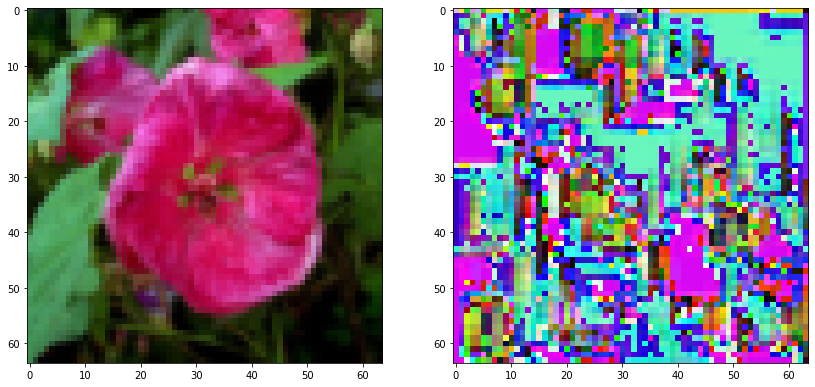

Base Caption: <start> the bloom of the flower is hot pink in color and the leaves of the flower are green in color . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


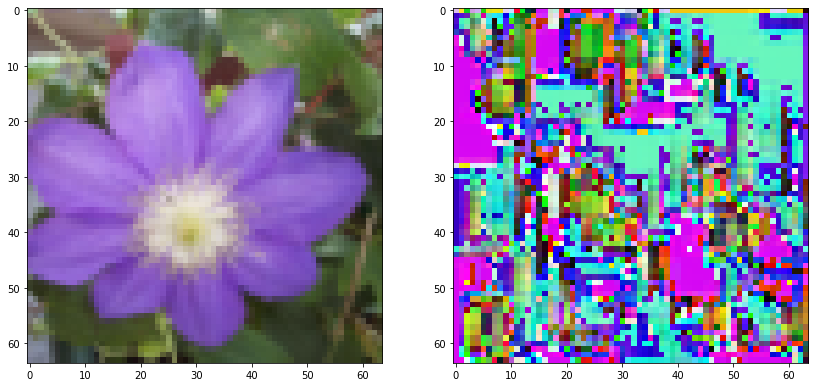

Base Caption: <start> the petals being purple and the filaments are white and the ovary is not seen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


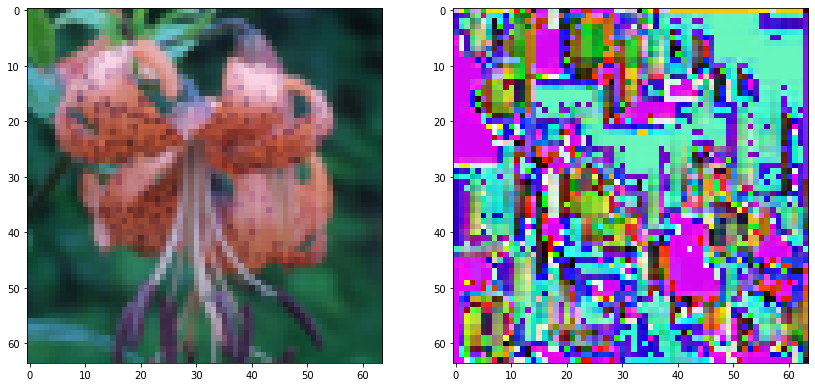

Base Caption: <start> this flower has curled salmon petals with black <unk> and long stamen with dark anthers . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


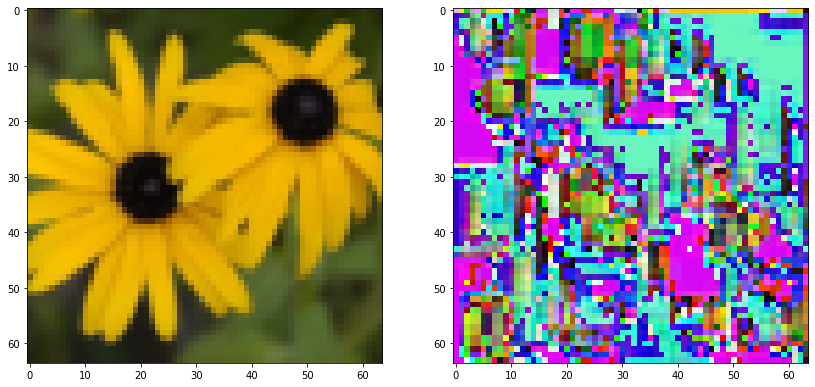

Base Caption: <start> the flower has thin and long bright yellow petals with black stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has red stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


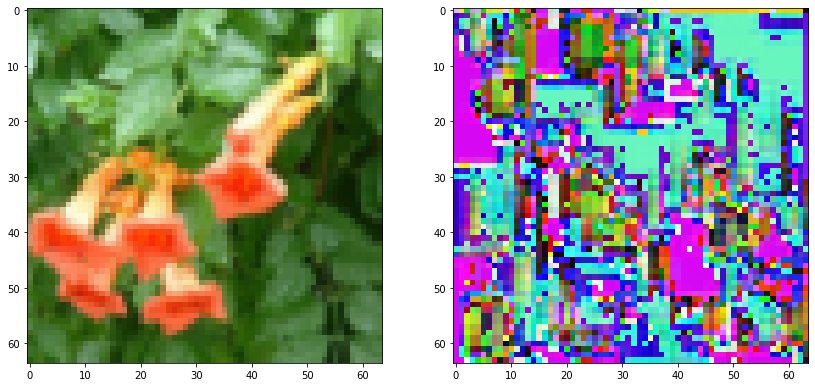

Base Caption: <start> this flower has petals that are orange and in a bell shape <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


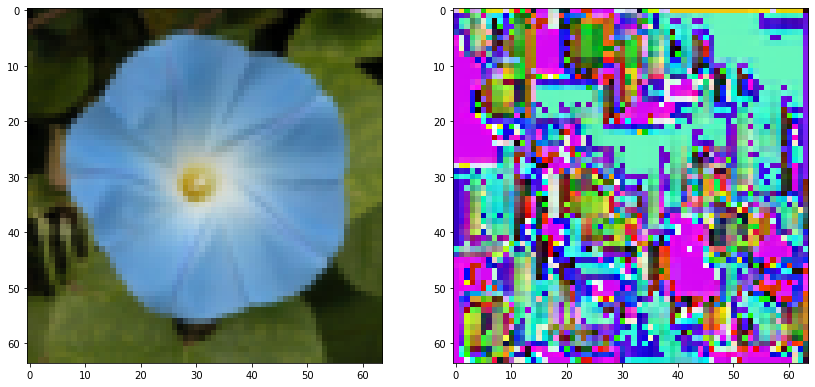

Base Caption: <start> this flower has petals that are blue and has a white center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are yellow and has black lines <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


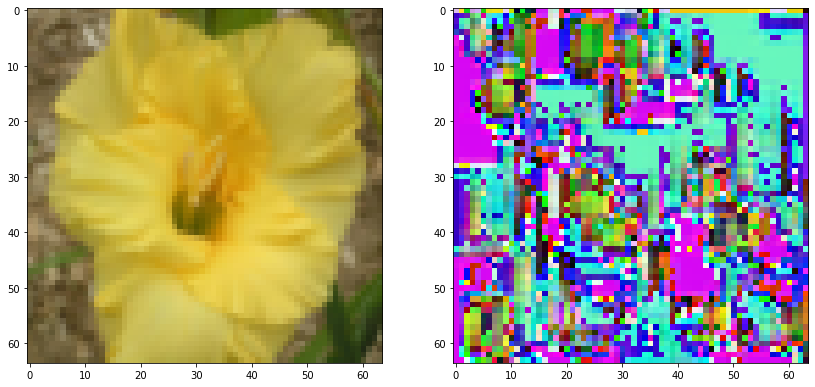

Base Caption: <start> the flower shown has yellow pistil with large flat yellow petals <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a purple center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


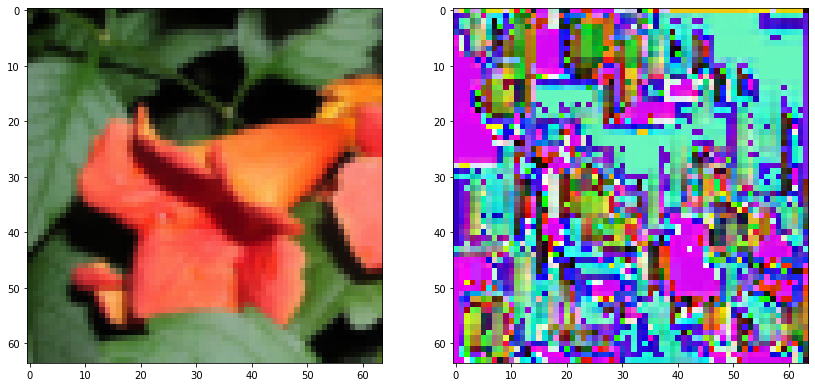

Base Caption: <start> this flower has orange and red petals shaped like bells . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


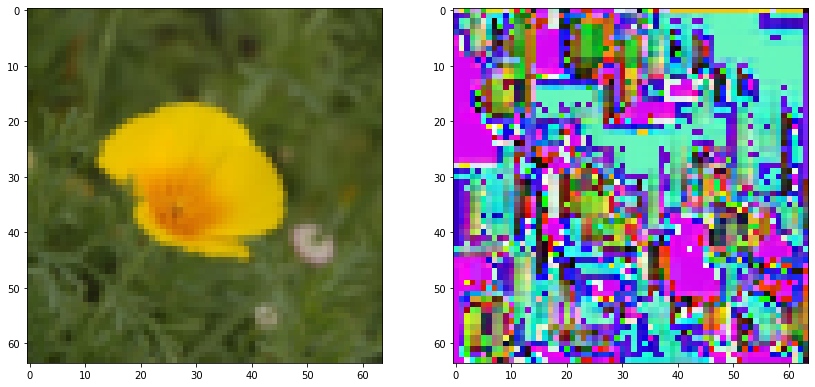

Base Caption: <start> this flower has petals that are yellow with yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


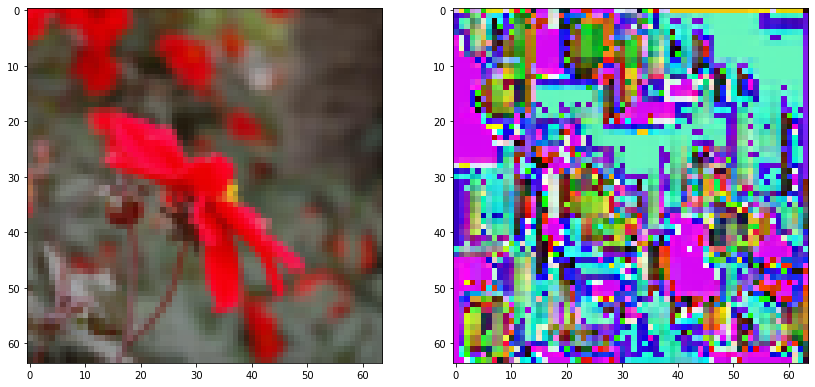

Base Caption: <start> this flower has red petals with yellow inside the middle <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
epoch0, iter2929, val loss: 10.743438021081392, epoch duration: 405.80902099609375


/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type BaseGenerator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Linear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/python3.7/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Upsample. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/opt/conda/lib/pyth

epoch1, iter0, loss: 10.515731811523438


202it [00:27,  8.21it/s]

epoch1, iter200, loss: 10.227738380432129


402it [00:52,  7.89it/s]

epoch1, iter400, loss: 10.707650184631348


602it [01:18,  7.84it/s]

epoch1, iter600, loss: 7.877089023590088


802it [01:44,  7.76it/s]

epoch1, iter800, loss: 9.719927787780762


1002it [02:10,  7.86it/s]

epoch1, iter1000, loss: 6.977684020996094


1202it [02:36,  7.34it/s]

epoch1, iter1200, loss: 9.116684913635254


1402it [03:03,  7.86it/s]

epoch1, iter1400, loss: 8.072532653808594


1602it [03:29,  7.81it/s]

epoch1, iter1600, loss: 9.398015022277832


1802it [03:55,  7.42it/s]

epoch1, iter1800, loss: 7.156574726104736


2002it [04:21,  7.69it/s]

epoch1, iter2000, loss: 9.593940734863281


2202it [04:47,  7.11it/s]

epoch1, iter2200, loss: 7.402148246765137


2402it [05:13,  7.53it/s]

epoch1, iter2400, loss: 9.184649467468262


2602it [05:40,  7.85it/s]

epoch1, iter2600, loss: 8.9636869430542


2802it [06:06,  7.32it/s]

epoch1, iter2800, loss: 6.062438011169434


2930it [06:24,  7.73it/s]


epoch1, iter2929, loss: 6.173871040344238, epoch duration: 385.4590742588043


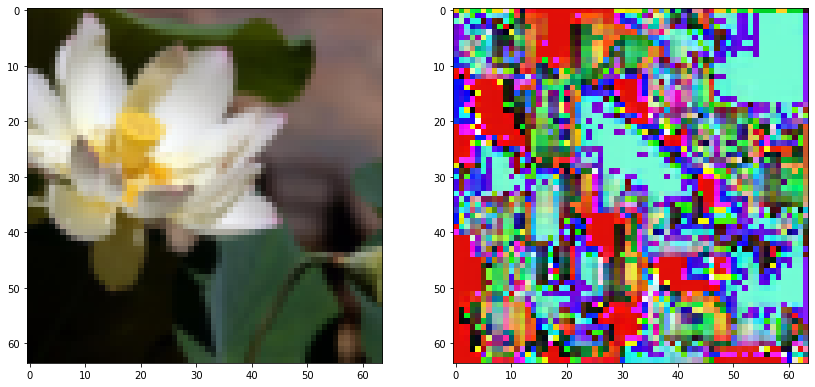

Base Caption: <start> the bright yellow pistil of this flower is ringed by vibrant yellow filaments and layers of white pointed oblong petals . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


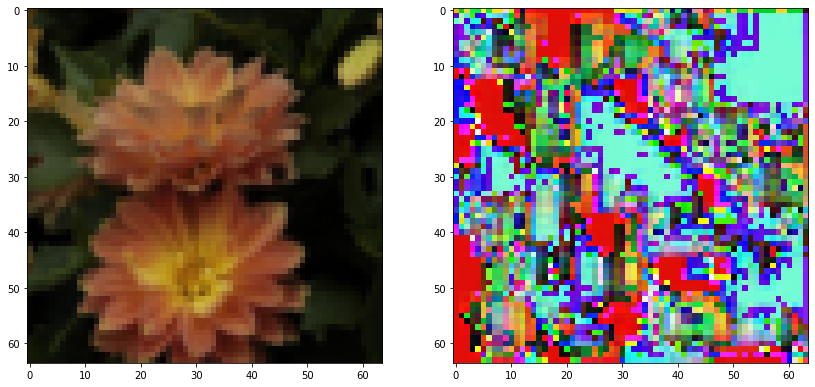

Base Caption: <start> this flower has a mound of small tapered petals in hues of pale peach and yellow . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are red and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


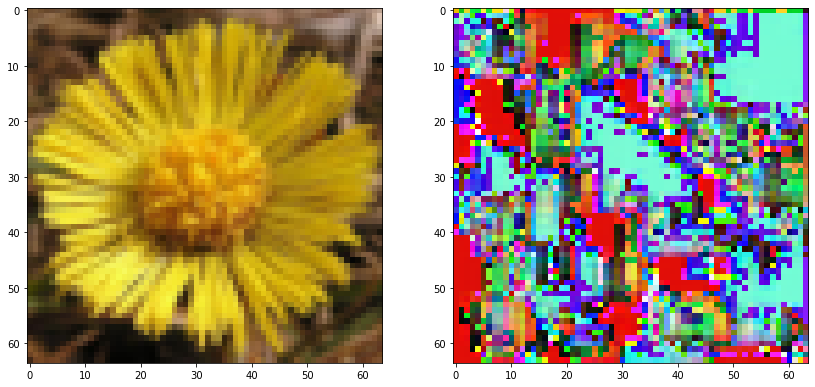

Base Caption: <start> the flower has petals that are thin and yellow with a large yellow center . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


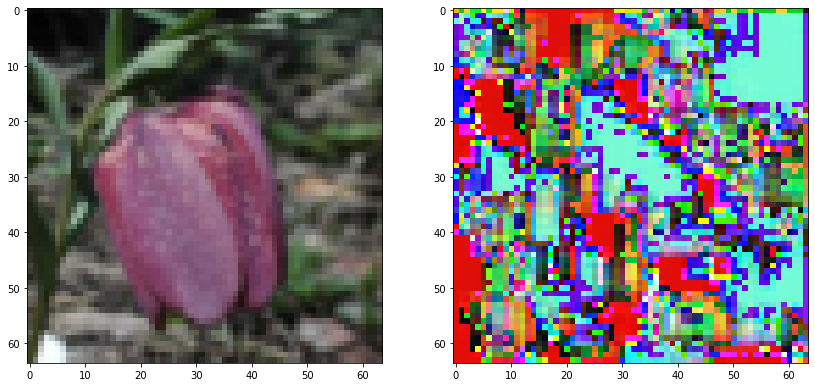

Base Caption: <start> this flower has purple petals and a green pedicel and is <unk> over <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are yellow and has a bell shape <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


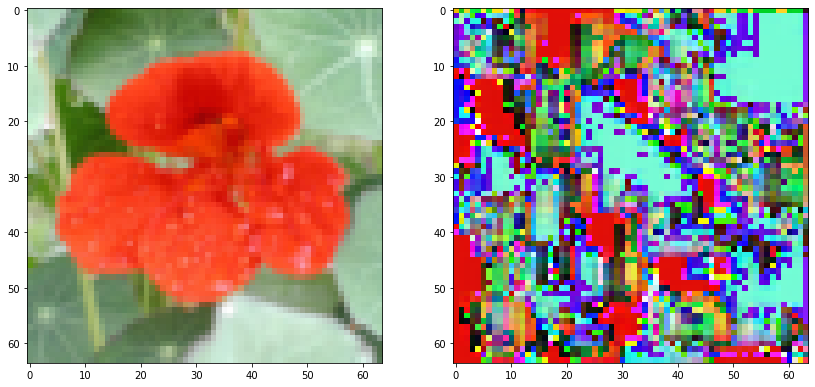

Base Caption: <start> this flower is red with small petals and large leafs surrounding it . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


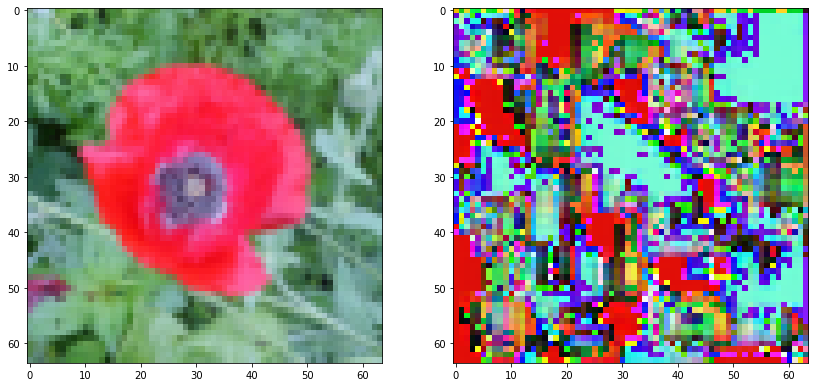

Base Caption: <start> the flower has bright red petals and blue stamen and pistil . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


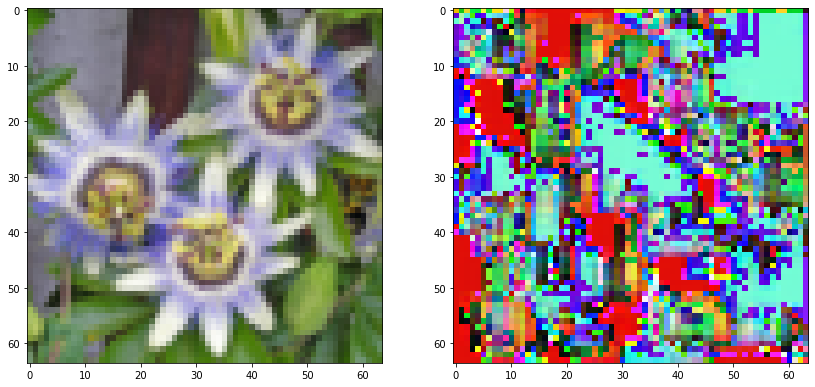

Base Caption: <start> this flower has white petals on the bottom layer <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


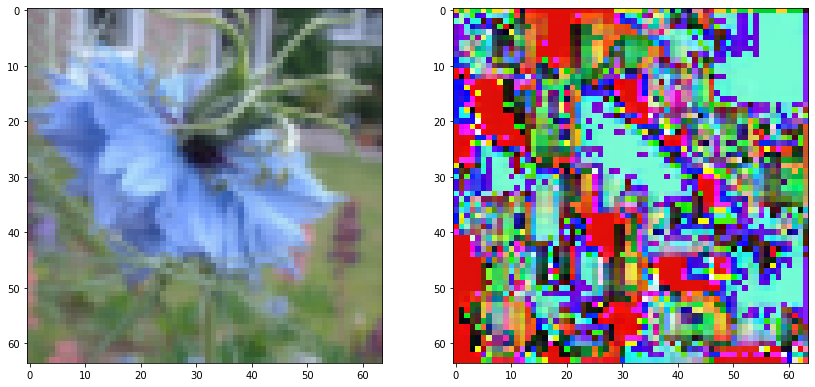

Base Caption: <start> this unusual blue flower has layered thin petals . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are orange and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


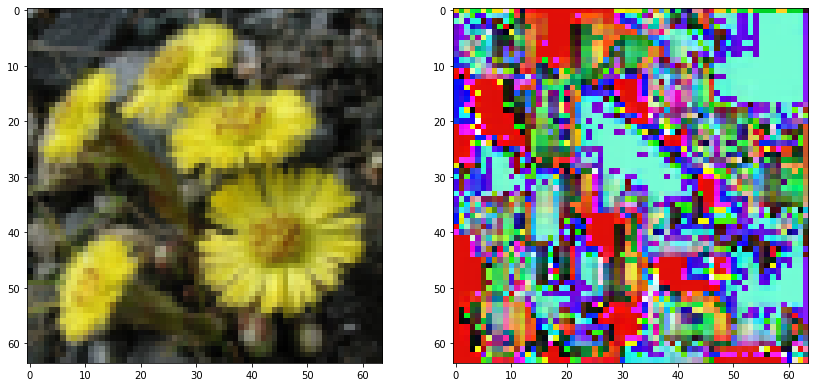

Base Caption: <start> this flower is yellow in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


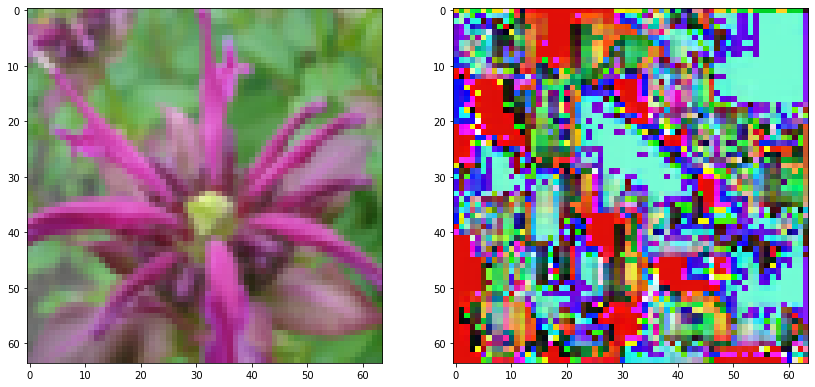

Base Caption: <start> this flower has purple petals <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
epoch1, iter2929, val loss: 10.856789263871198, epoch duration: 432.3547930717468


1it [00:01,  1.48s/it]

epoch2, iter0, loss: 6.443820953369141


202it [00:27,  7.80it/s]

epoch2, iter200, loss: 1.5390019416809082


402it [00:53,  7.90it/s]

epoch2, iter400, loss: -0.2271556854248047


602it [01:20,  8.03it/s]

epoch2, iter600, loss: -1.9165267944335938


802it [01:46,  7.46it/s]

epoch2, iter800, loss: -4.194323539733887


1002it [02:12,  7.58it/s]

epoch2, iter1000, loss: -4.944984436035156


1202it [02:38,  7.86it/s]

epoch2, iter1200, loss: -2.8735132217407227


1402it [03:04,  7.54it/s]

epoch2, iter1400, loss: -3.0203685760498047


1602it [03:30,  7.69it/s]

epoch2, iter1600, loss: -6.637012958526611


1802it [03:56,  7.69it/s]

epoch2, iter1800, loss: -6.935541152954102


2002it [04:22,  7.25it/s]

epoch2, iter2000, loss: -5.316191673278809


2202it [04:48,  7.58it/s]

epoch2, iter2200, loss: -4.355975151062012


2402it [05:14,  7.45it/s]

epoch2, iter2400, loss: -5.094176292419434


2602it [05:40,  7.55it/s]

epoch2, iter2600, loss: -6.061095714569092


2802it [06:07,  7.63it/s]

epoch2, iter2800, loss: -6.278231620788574


2930it [06:24,  7.10it/s]


epoch2, iter2929, loss: -3.0118627548217773, epoch duration: 385.590701341629


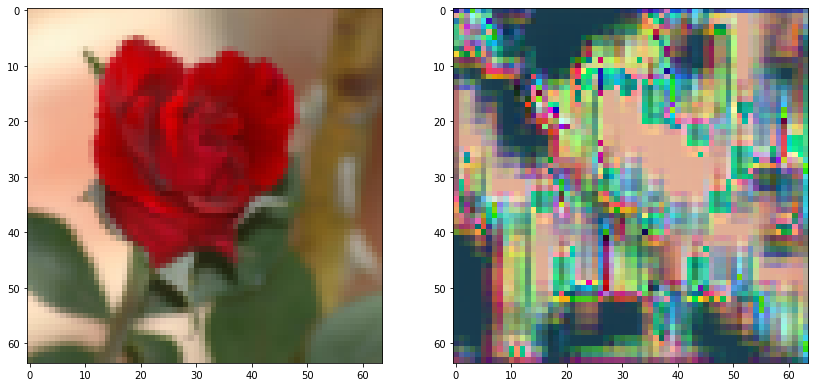

Base Caption: <start> beautiful red petals that are wrapped around each other tightly in the center of the flower but begin to spread open as the reach the outer area of the flower . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


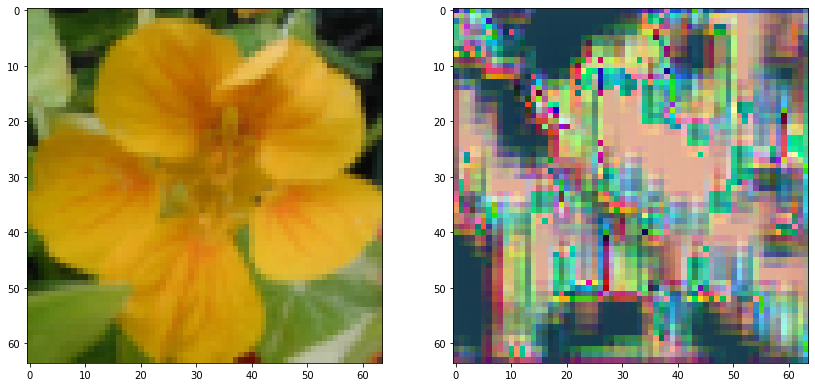

Base Caption: <start> the flowers has a set of 5 petals that 's yellow in color with orange vein like patterns on it . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has a flowery stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


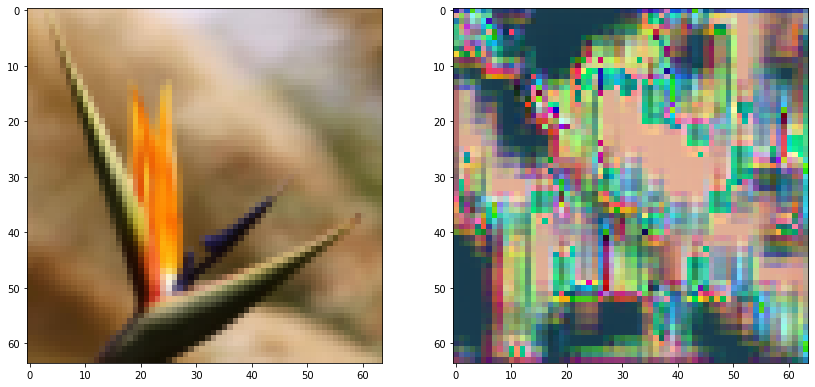

Base Caption: <start> this flower has sharp green sepals and sparse orange petals with pointed tips . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has a flowery stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


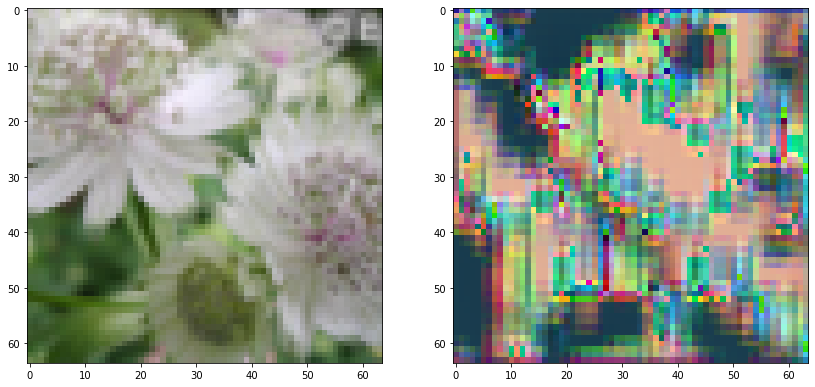

Base Caption: <start> flower with white petals with a green tip and purple stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has red dots <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


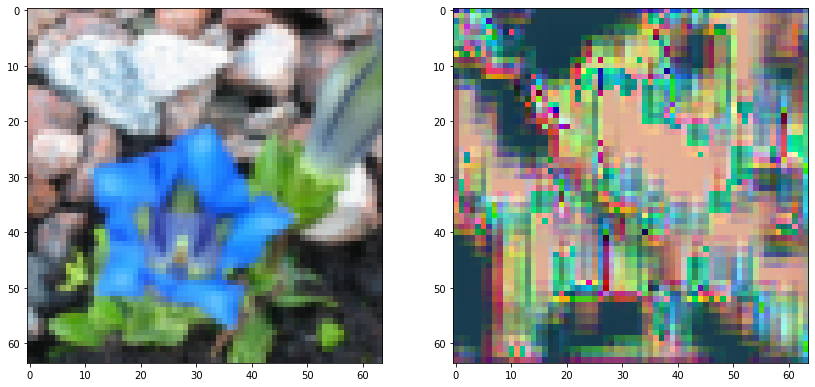

Base Caption: <start> the flower shown has bright blue petals and a yellow stigma . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a flowery stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


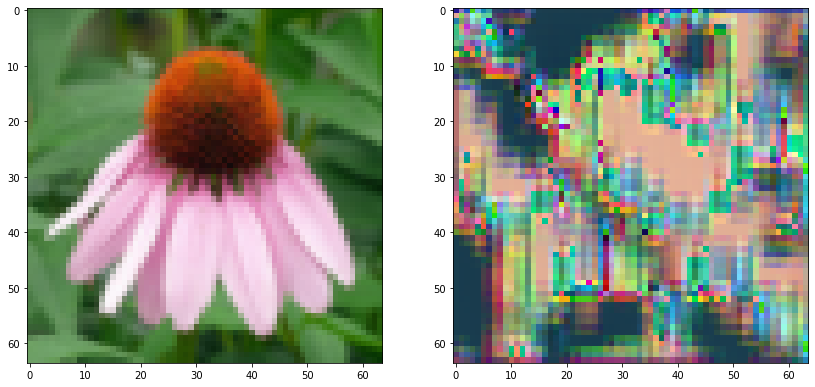

Base Caption: <start> this flower has petals that are pink with red stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a flowery stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


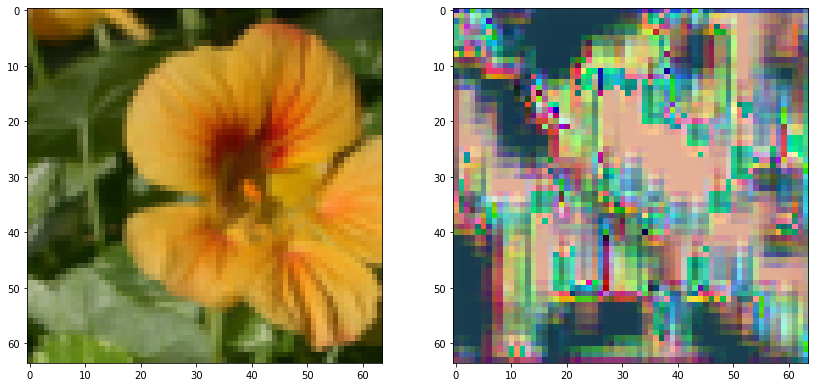

Base Caption: <start> this flower is orange and red in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


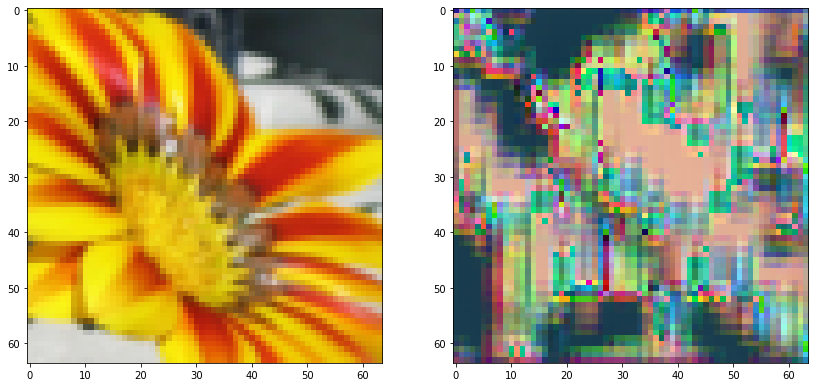

Base Caption: <start> this flower is yellow and red in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


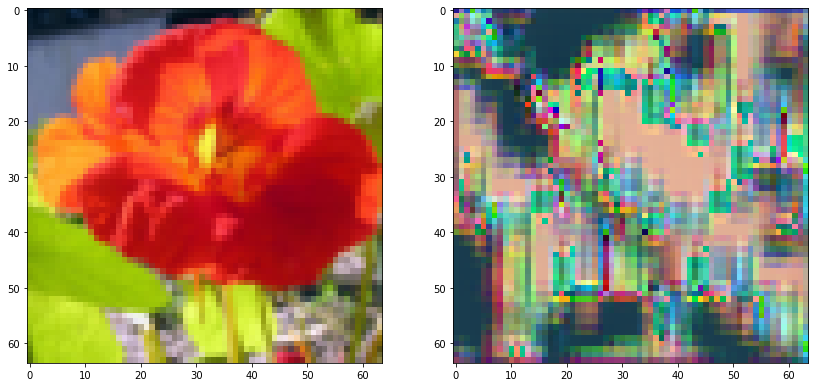

Base Caption: <start> this flower has several large <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are orange and has yellow shading <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


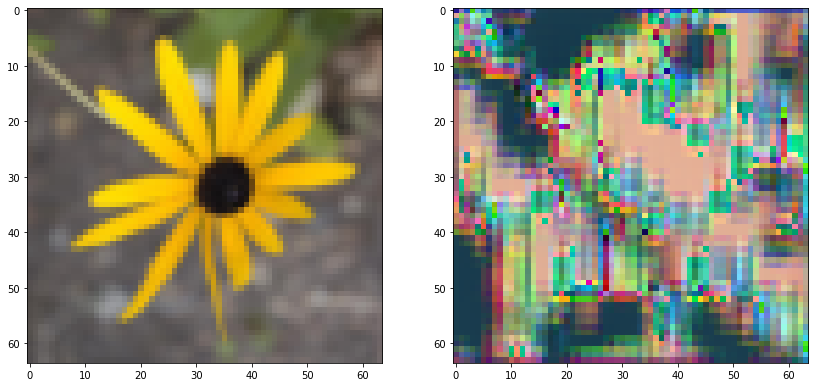

Base Caption: <start> this flower has long <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
epoch2, iter2929, val loss: 10.657281706241962, epoch duration: 433.2221579551697


1it [00:01,  1.34s/it]

epoch3, iter0, loss: -3.6298980712890625


202it [00:27,  7.81it/s]

epoch3, iter200, loss: -7.645593643188477


402it [00:54,  7.70it/s]

epoch3, iter400, loss: -6.638357162475586


602it [01:20,  7.62it/s]

epoch3, iter600, loss: -6.919397354125977


802it [01:46,  7.60it/s]

epoch3, iter800, loss: -6.616312503814697


1002it [02:10,  7.22it/s]

epoch3, iter1000, loss: -3.829408645629883


1202it [02:37,  7.76it/s]

epoch3, iter1200, loss: -6.951470375061035


1402it [03:03,  8.11it/s]

epoch3, iter1400, loss: -7.630572319030762


1602it [03:29,  7.48it/s]

epoch3, iter1600, loss: -6.428487777709961


1802it [03:55,  7.64it/s]

epoch3, iter1800, loss: -7.398968696594238


2002it [04:21,  7.57it/s]

epoch3, iter2000, loss: -7.621667385101318


2202it [04:48,  7.70it/s]

epoch3, iter2200, loss: -6.375095367431641


2402it [05:14,  7.94it/s]

epoch3, iter2400, loss: -7.021254539489746


2602it [05:40,  8.02it/s]

epoch3, iter2600, loss: -5.573376655578613


2802it [06:06,  7.69it/s]

epoch3, iter2800, loss: -5.035569190979004


2930it [06:23,  7.19it/s]


epoch3, iter2929, loss: -4.8742780685424805, epoch duration: 384.9608750343323


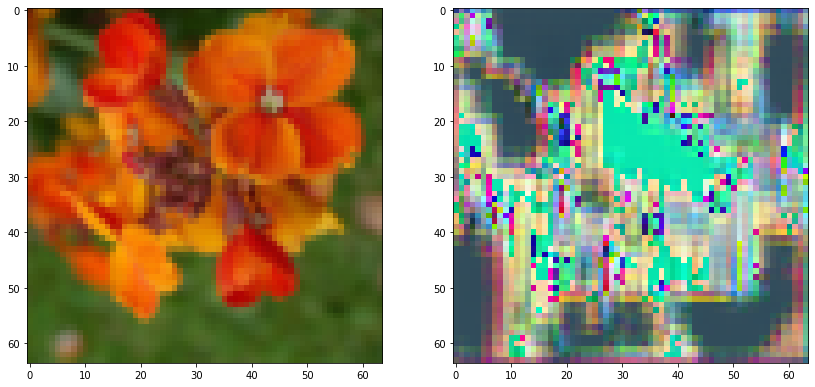

Base Caption: <start> this flower has petals that open out flat and are orange veined with dark orange and yellow at edges . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a yellow style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


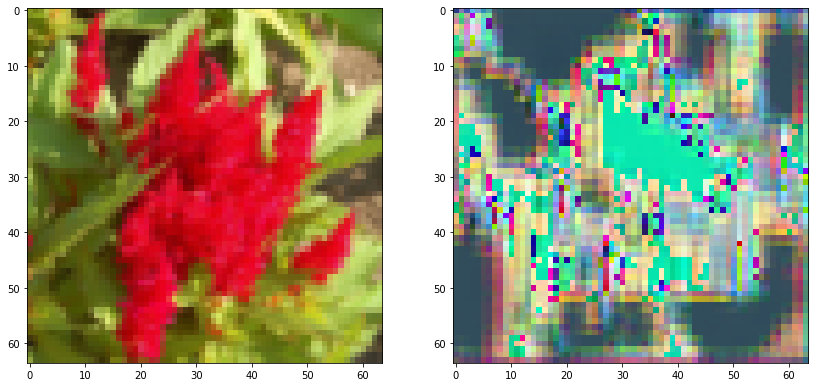

Base Caption: <start> this flower has a lot of red petals that are stacked up on each other <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


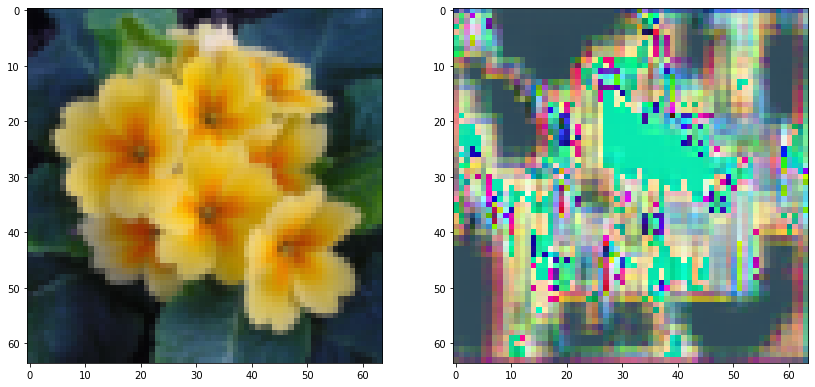

Base Caption: <start> this flower has small heart shaped petals in <unk> shades of yellow . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a flowery stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


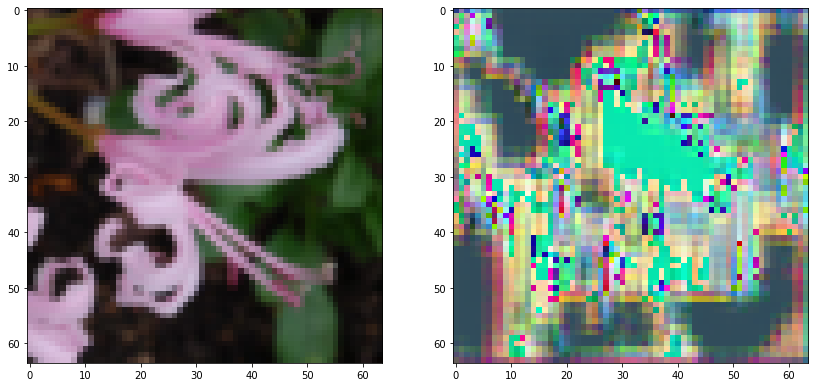

Base Caption: <start> the flower stamen are long and pin <unk> in color with larger anthers <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple with yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


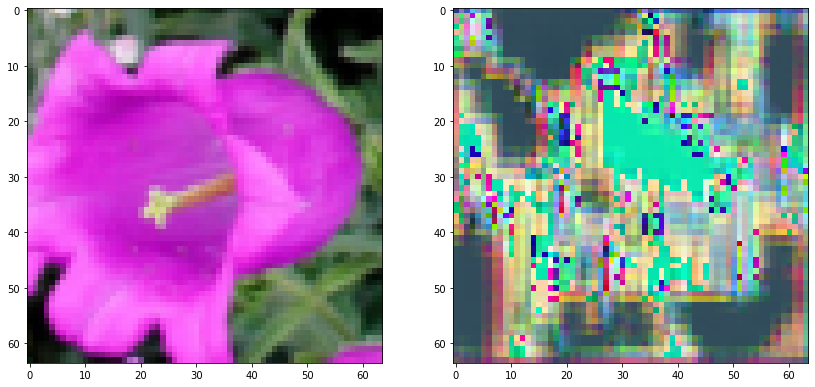

Base Caption: <start> a six petaled fuchsia bell shape flower with a yellow white stigma . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are yellow and has orange shading <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


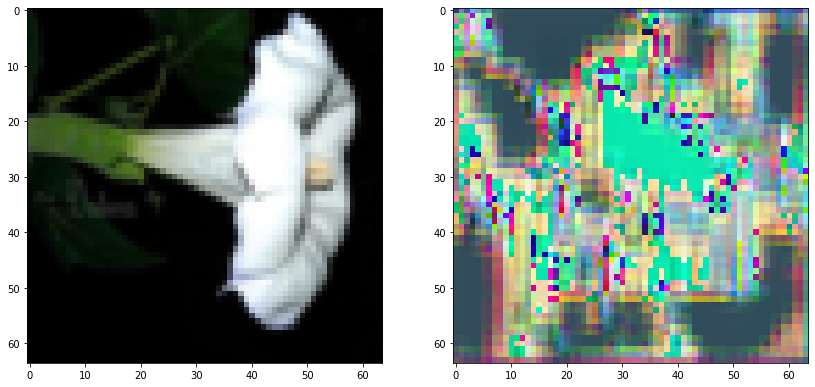

Base Caption: <start> the petals on this flower are white with yellow stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a flowery stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


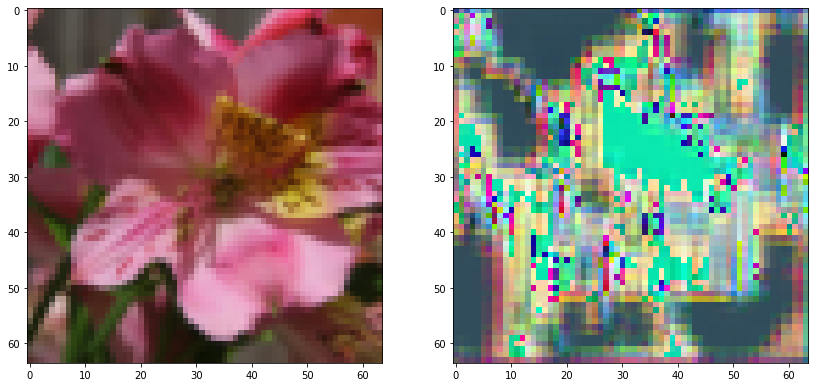

Base Caption: <start> this flower has petals that are pink and has yellow patches <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a flowery stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


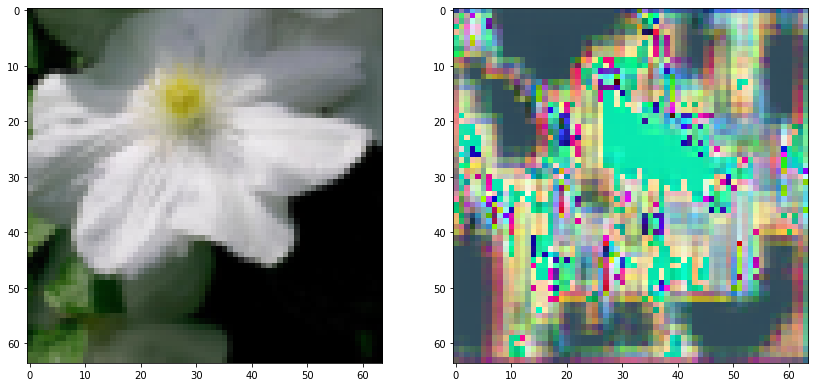

Base Caption: <start> the flower petals is large and white with a yellow inside <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple with yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


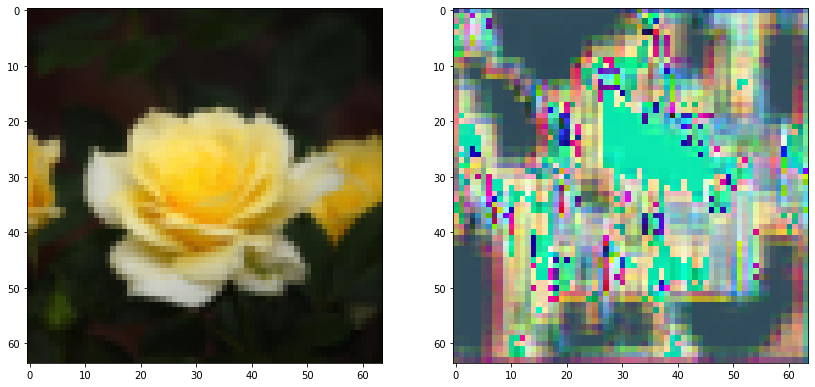

Base Caption: <start> this flower has petals that are yellow and has white shading <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


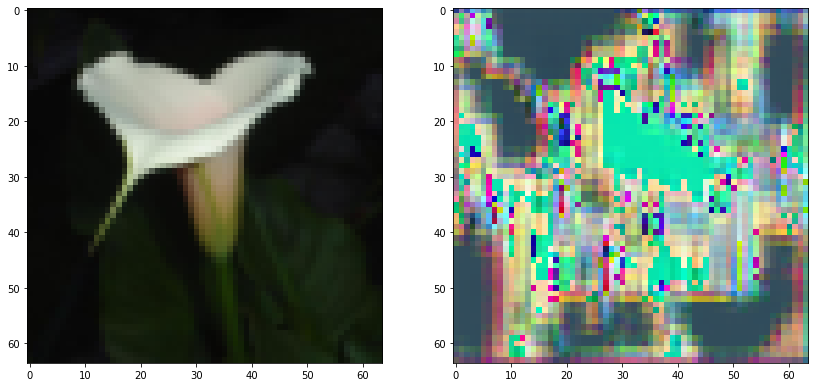

Base Caption: <start> this flower is white and green in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
epoch3, iter2929, val loss: 10.60645954791314, epoch duration: 433.72711849212646


1it [00:01,  1.41s/it]

epoch4, iter0, loss: -6.670221328735352


202it [00:27,  7.63it/s]

epoch4, iter200, loss: -4.7364912033081055


402it [00:53,  8.25it/s]

epoch4, iter400, loss: -5.935474395751953


602it [01:20,  7.94it/s]

epoch4, iter600, loss: -4.891637802124023


802it [01:46,  7.39it/s]

epoch4, iter800, loss: -7.4558916091918945


1002it [02:12,  8.74it/s]

epoch4, iter1000, loss: -5.933194160461426


1202it [02:38,  7.43it/s]

epoch4, iter1200, loss: -6.605498313903809


1402it [03:04,  7.79it/s]

epoch4, iter1400, loss: -6.665766716003418


1602it [03:30,  7.85it/s]

epoch4, iter1600, loss: -7.500194072723389


1802it [03:55,  7.59it/s]

epoch4, iter1800, loss: -6.693076133728027


2002it [04:21,  7.46it/s]

epoch4, iter2000, loss: -7.566658020019531


2202it [04:47,  7.54it/s]

epoch4, iter2200, loss: -6.759466171264648


2402it [05:12,  7.66it/s]

epoch4, iter2400, loss: -7.1449360847473145


2602it [05:38,  7.75it/s]

epoch4, iter2600, loss: -8.385104179382324


2802it [06:04,  7.63it/s]

epoch4, iter2800, loss: -6.4810333251953125


2930it [06:20,  7.78it/s]


epoch4, iter2929, loss: -5.558008193969727, epoch duration: 382.2478678226471


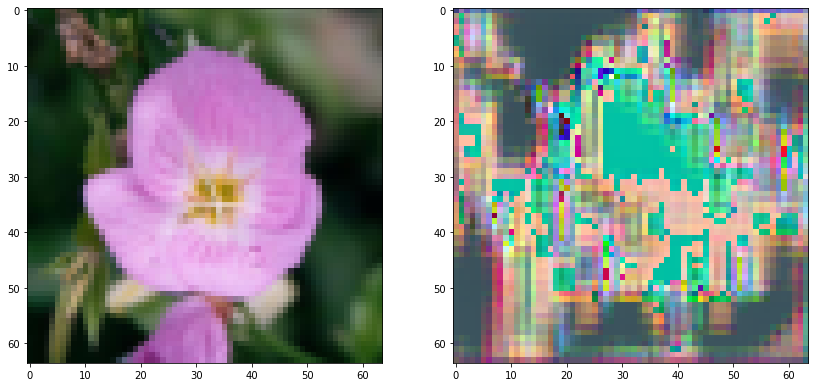

Base Caption: <start> the <unk> shapes of the bright purple petals set off the orange stamen and filament and the cross shaped stigma is beautiful . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are yellow and has red lines <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


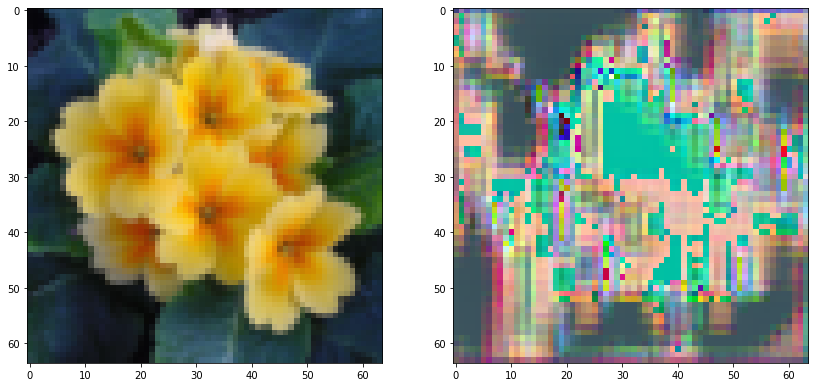

Base Caption: <start> these flowers ' petals are white at the part furthest from the center of the flower <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a yellow center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


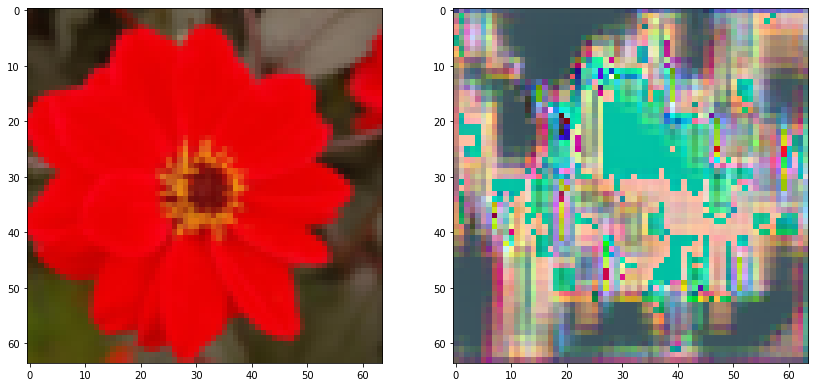

Base Caption: <start> overlapping bright red petals encircle a yellow stigma and burgundy stamen in this flower . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


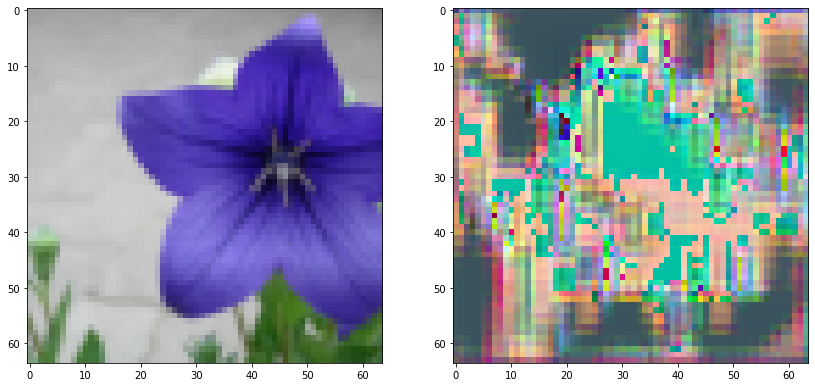

Base Caption: <start> the petals on this flower are purple with white stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


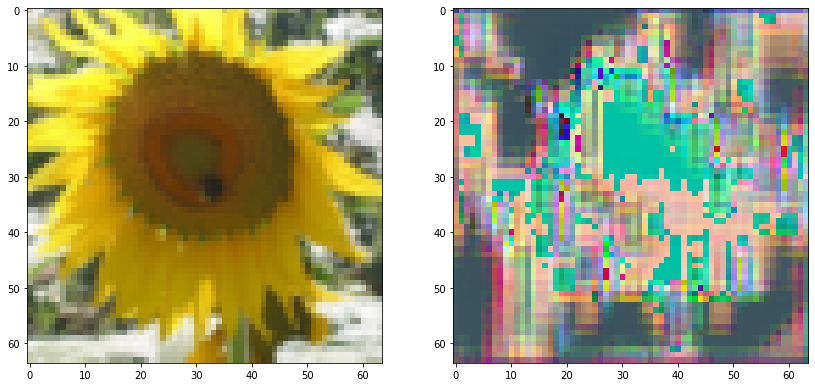

Base Caption: <start> the flower is so big with yellow petals that are soft <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are white and has purple stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


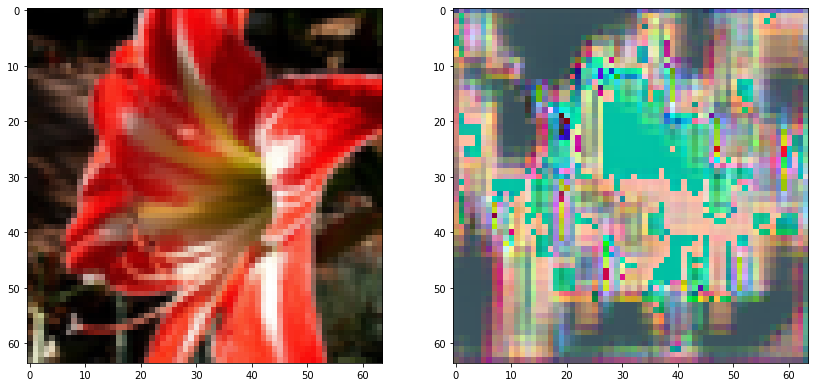

Base Caption: <start> this flower has petals that are purple and has white lines <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


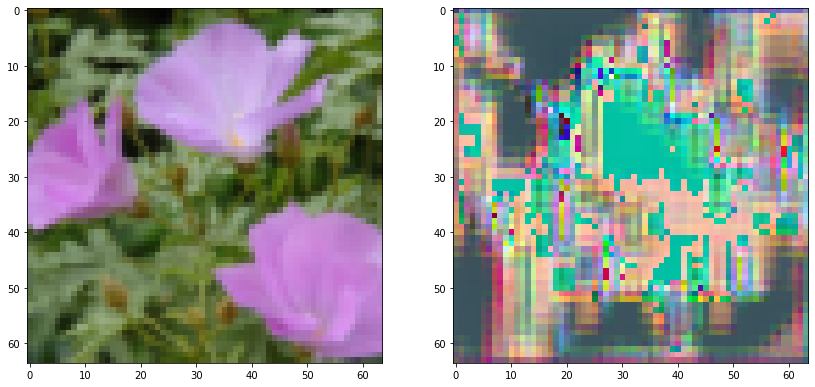

Base Caption: <start> the pedals of this flower are lavender with a short stigma <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has white edges <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


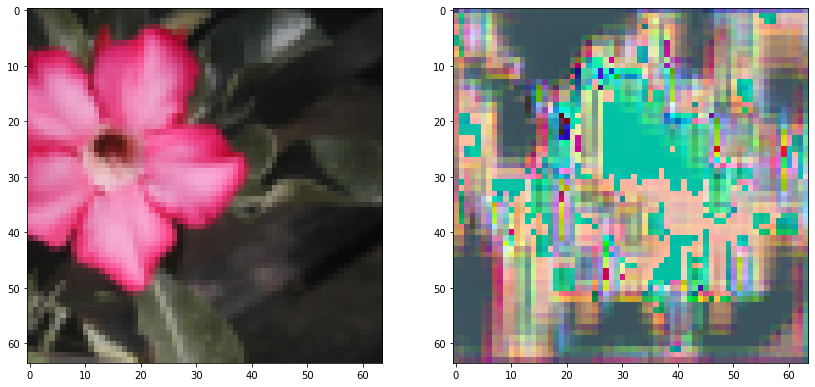

Base Caption: <start> this flower is pink and white in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


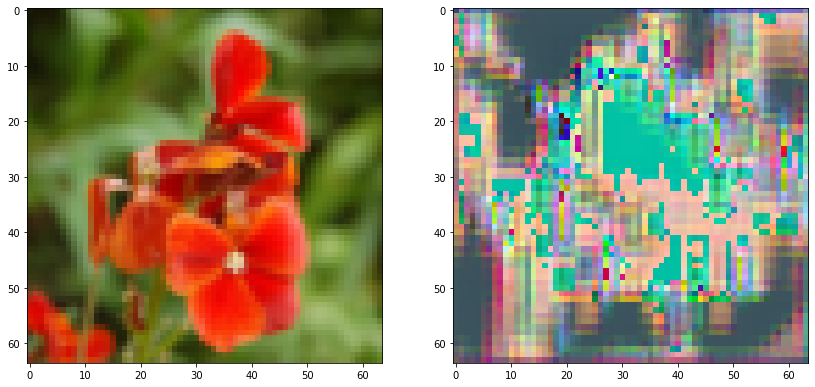

Base Caption: <start> this flower is red and orange in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


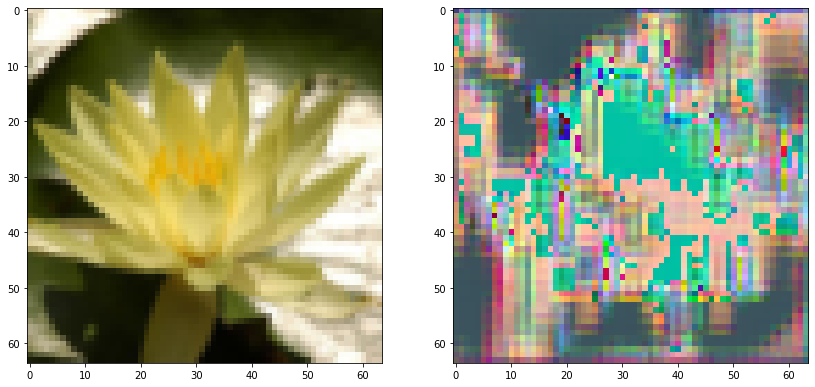

Base Caption: <start> this flower is yellow in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
epoch4, iter2929, val loss: 10.760232855713433, epoch duration: 430.14120602607727


1it [00:01,  1.57s/it]

epoch5, iter0, loss: 14.9603853225708


203it [00:17, 12.78it/s]

epoch5, iter200, loss: 0.000438762828707695


403it [00:32, 12.22it/s]

epoch5, iter400, loss: 0.00022120025823824108


603it [00:48, 13.34it/s]

epoch5, iter600, loss: 0.00010317814303562045


803it [01:04, 11.73it/s]

epoch5, iter800, loss: 9.032672096509486e-05


1003it [01:20, 13.53it/s]

epoch5, iter1000, loss: 7.874125731177628e-05


1203it [01:36, 12.63it/s]

epoch5, iter1200, loss: 5.313611472956836e-05


1403it [01:51, 13.51it/s]

epoch5, iter1400, loss: 3.712727630045265e-05


1603it [02:07, 13.71it/s]

epoch5, iter1600, loss: 5.848565342603251e-05


1803it [02:22, 13.50it/s]

epoch5, iter1800, loss: 3.3258809708058834e-05


2003it [02:37, 13.56it/s]

epoch5, iter2000, loss: 2.688136555661913e-05


2203it [02:53, 13.42it/s]

epoch5, iter2200, loss: 2.1981870304443873e-05


2403it [03:09, 13.69it/s]

epoch5, iter2400, loss: 2.0378596673253924e-05


2603it [03:24, 13.73it/s]

epoch5, iter2600, loss: 1.766667264746502e-05


2803it [03:39, 13.56it/s]

epoch5, iter2800, loss: 2.1719595679314807e-05


2930it [03:49, 12.76it/s]


epoch5, iter2929, loss: 1.2457323464332148e-05, epoch duration: 230.87705373764038


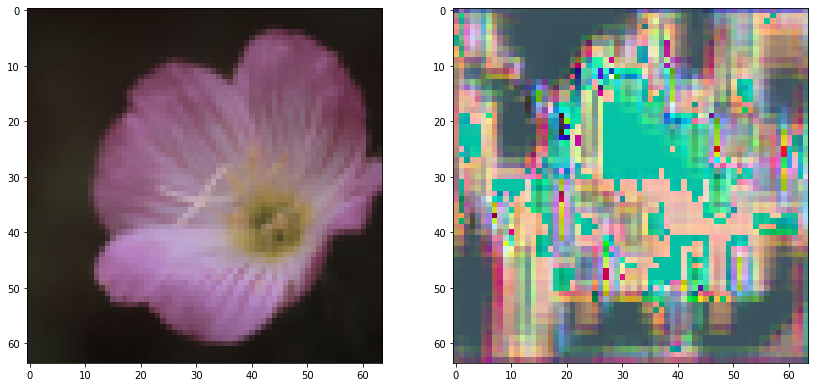

Base Caption: <start> the magenta flower with pale pink ridges on its petals has many yellow stamen and a yellow green center . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


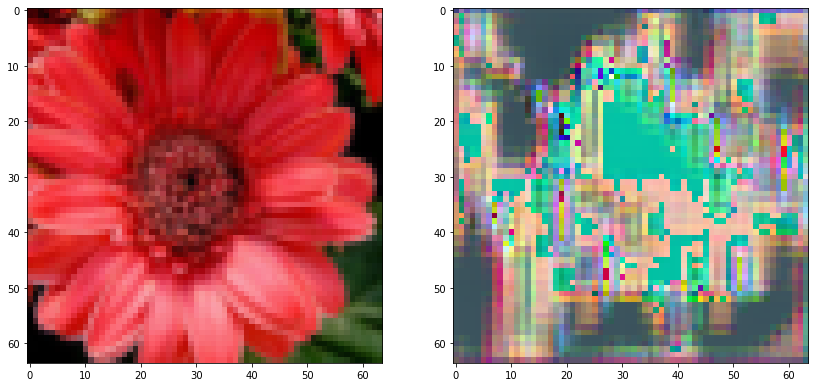

Base Caption: <start> this flower has a couple of layers of oblong bright pink petals in a ray-like arrangement . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has a white center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


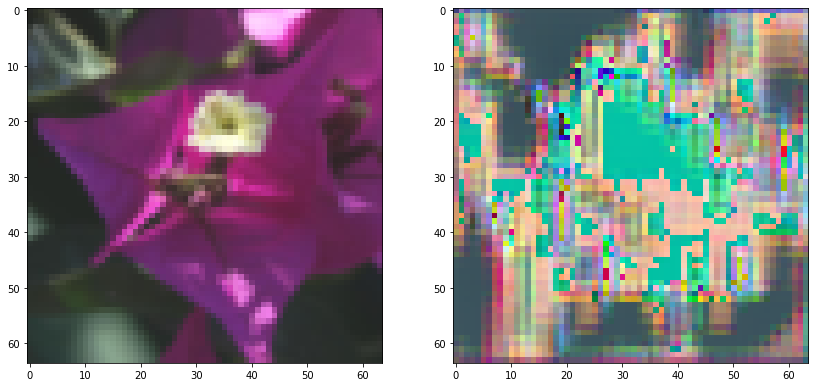

Base Caption: <start> this flower has purple leaves with veins and pointed tips surrounding a tiny white blossom . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


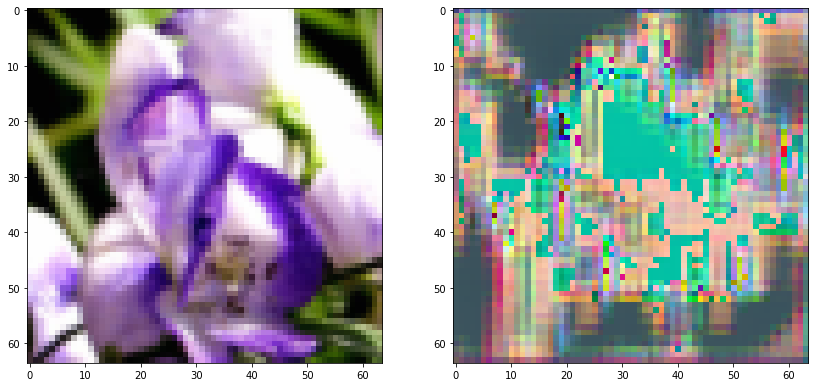

Base Caption: <start> purple flowers with purple petals curling up and stigma and pollen tube showing <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


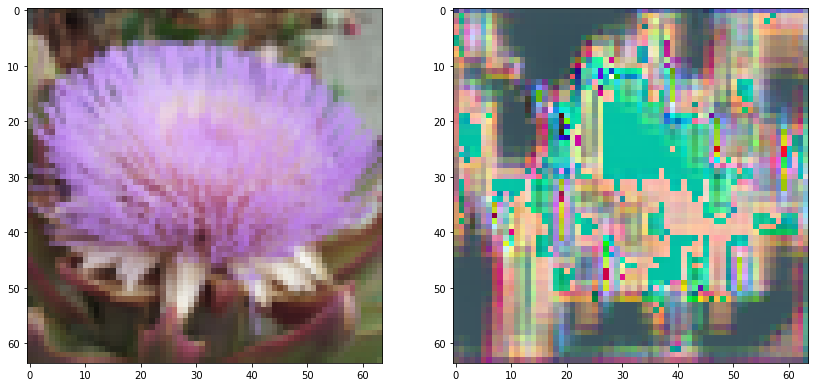

Base Caption: <start> the flower has dense petals that are cream colored and sharp . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a big style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


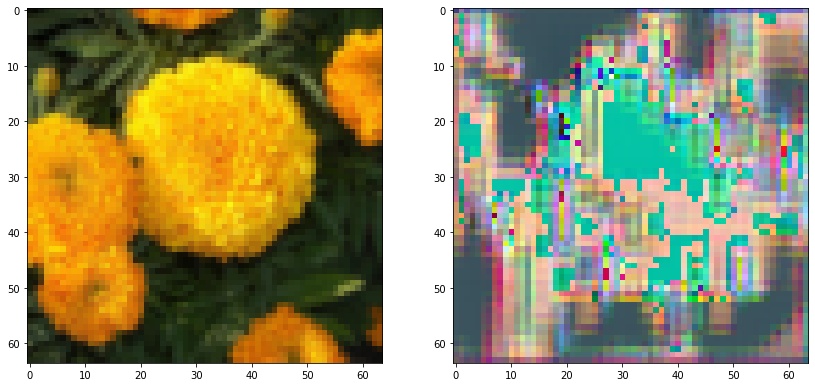

Base Caption: <start> this flower has petals that are yellow and are ruffled together <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are yellow and has red dots <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


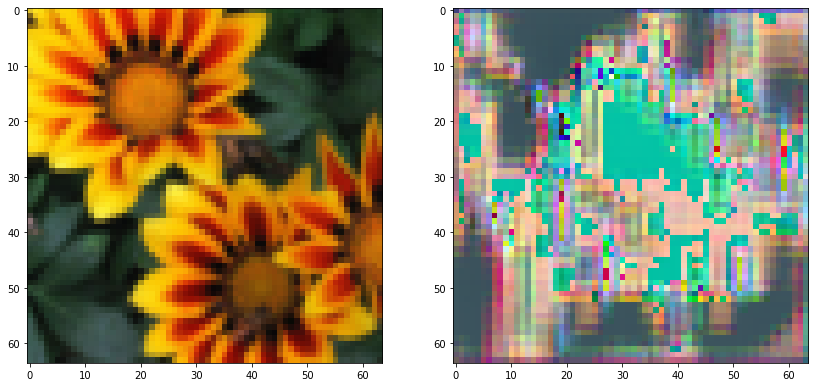

Base Caption: <start> this flower has petals that are yellow and has red stripes <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


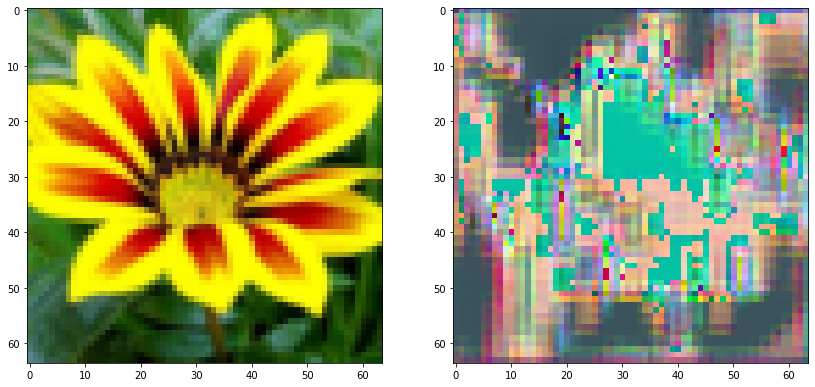

Base Caption: <start> this flower has bright petals with pointed tips <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has a white center <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


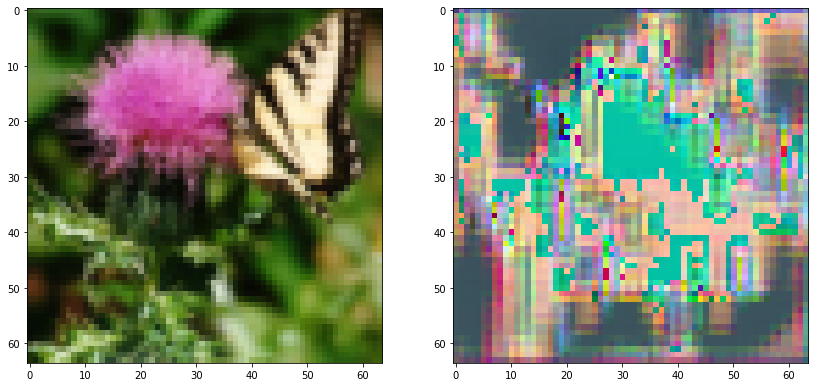

Base Caption: <start> this flower is pink and <unk> color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has white shading <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


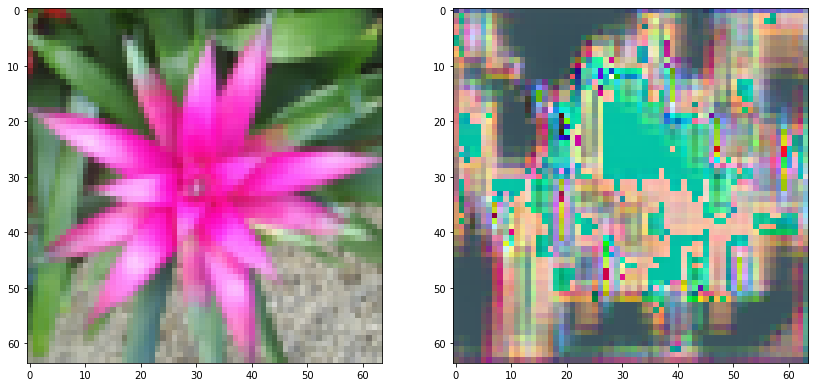

Base Caption: <start> this flower is pink in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are yellow and has red lines <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
epoch5, iter2929, val loss: 10.606570199539101, epoch duration: 277.29149985313416


2it [00:01,  1.14s/it]

epoch6, iter0, loss: 6.134191989898682


202it [00:27,  7.18it/s]

epoch6, iter200, loss: 7.893321514129639


402it [00:55,  7.26it/s]

epoch6, iter400, loss: 8.827449798583984


602it [01:21,  7.77it/s]

epoch6, iter600, loss: 7.9477620124816895


802it [01:48,  7.69it/s]

epoch6, iter800, loss: 9.749913215637207


1002it [02:14,  7.55it/s]

epoch6, iter1000, loss: 10.393038749694824


1202it [02:40,  7.73it/s]

epoch6, iter1200, loss: 5.196532726287842


1402it [03:07,  7.51it/s]

epoch6, iter1400, loss: 6.634288311004639


1602it [03:33,  7.62it/s]

epoch6, iter1600, loss: 7.086542129516602


1802it [03:59,  7.49it/s]

epoch6, iter1800, loss: 10.175878524780273


2002it [04:26,  7.50it/s]

epoch6, iter2000, loss: 10.402400016784668


2202it [04:52,  7.66it/s]

epoch6, iter2200, loss: 11.114889144897461


2402it [05:19,  7.52it/s]

epoch6, iter2400, loss: 9.584704399108887


2602it [05:46,  7.12it/s]

epoch6, iter2600, loss: 6.728262901306152


2802it [06:13,  6.96it/s]

epoch6, iter2800, loss: 6.430473804473877


2930it [06:30,  7.51it/s]


epoch6, iter2929, loss: 7.029821395874023, epoch duration: 392.1970820426941


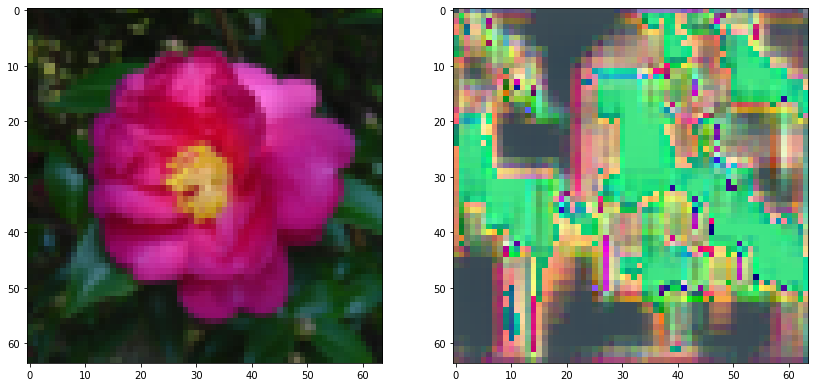

Base Caption: <start> the petals of the flower are pink in color and have a yellow center composed of anthers . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


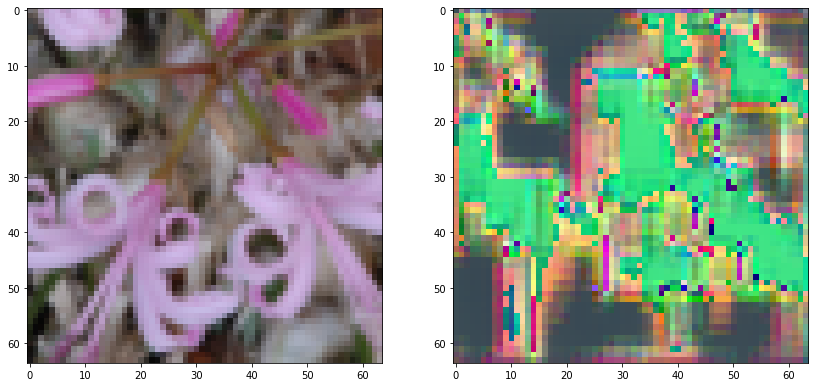

Base Caption: <start> the flowers have thin pink petals that are curled and are attached to a thick green stem . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


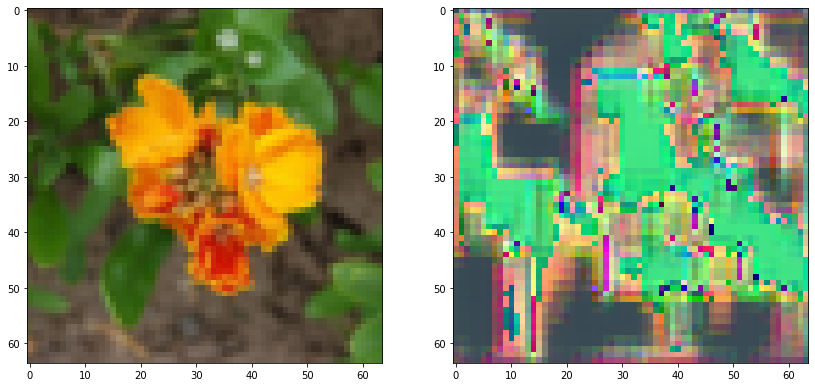

Base Caption: <start> the flower has small round petals that are yellow and orange colored . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are yellow and has red lines <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


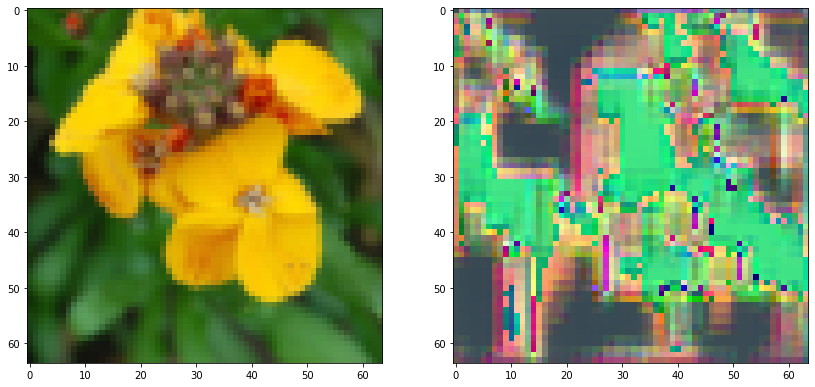

Base Caption: <start> this flower has yellow petals as well as a white stamen . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


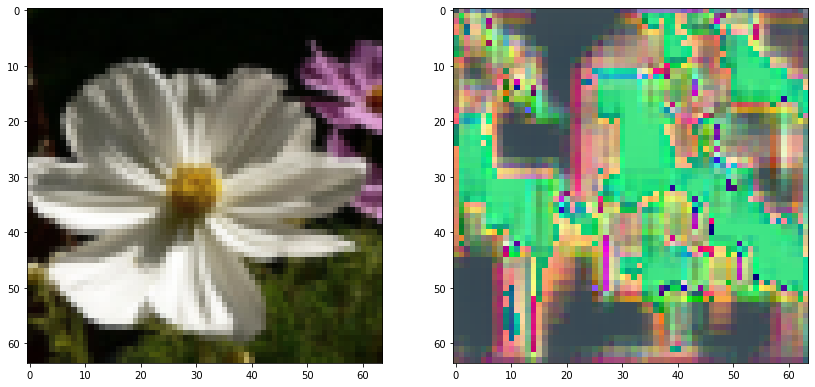

Base Caption: <start> this flower has petals that are white and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


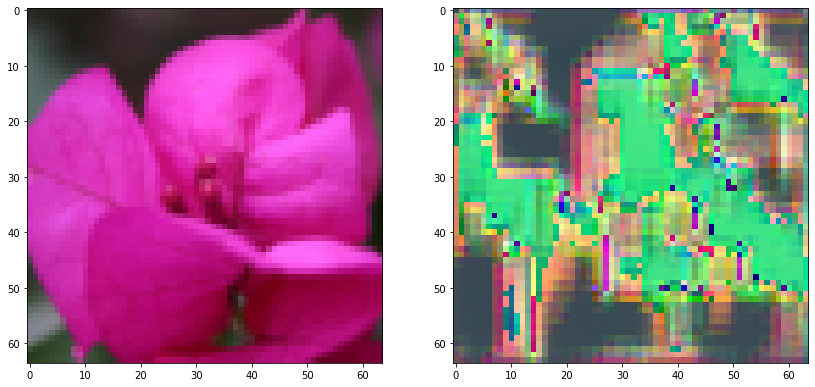

Base Caption: <start> the flower has three large purple colored petals with large stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has a big style <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


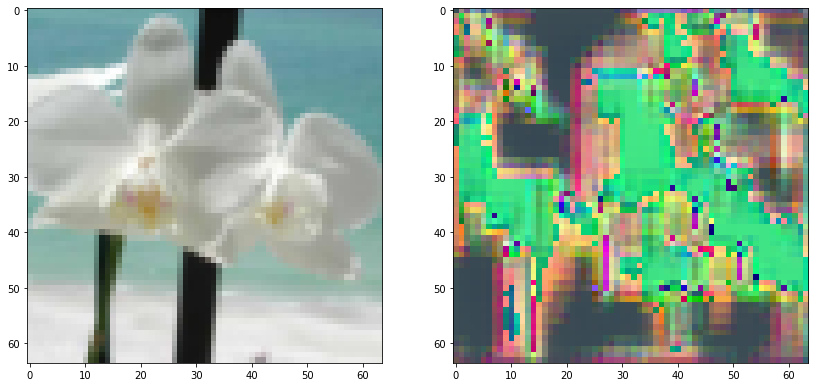

Base Caption: <start> the flower with separate petals which are white in color . <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


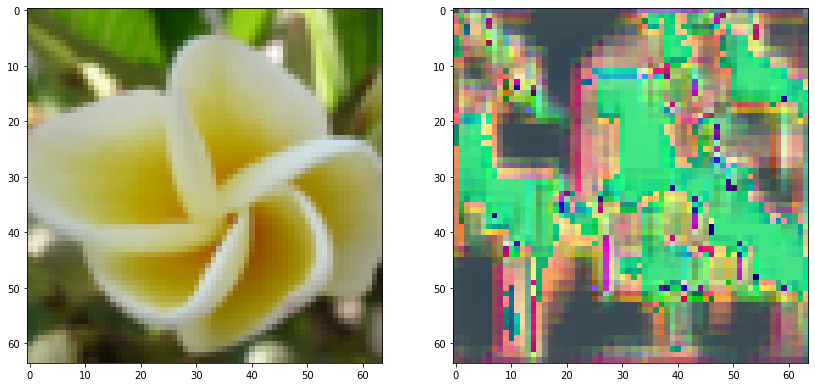

Base Caption: <start> a unique flower with <unk> petal surrounded by green leaves <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


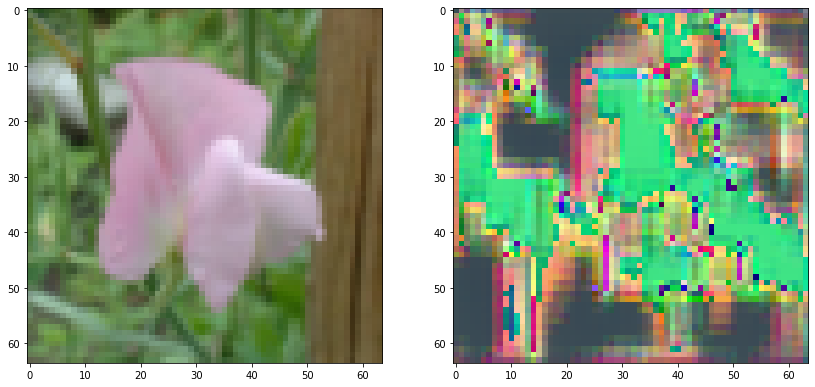

Base Caption: <start> this flower is pink and white in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are purple and has white stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


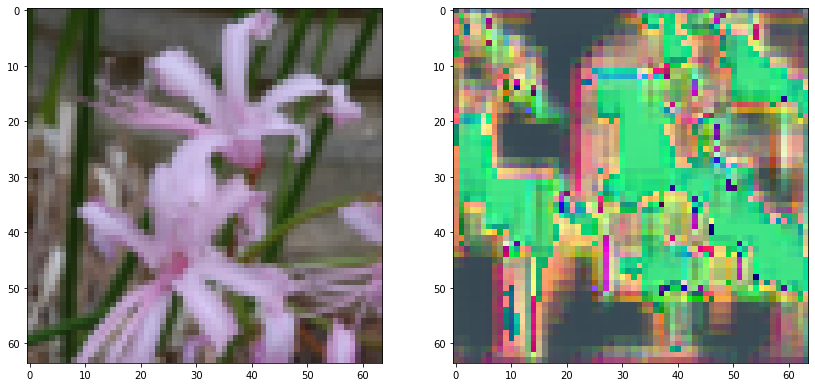

Base Caption: <start> this flower is pink in color <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>
Generated Caption: <start> this flower has petals that are pink and has yellow stamen <end> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>


In [ ]:
if __name__=='__main__':
    with open('trainvalIds.csv', 'r') as f:
        trainIds = []
        for line in f:
            if len(line) > 1:
                trainIds.append(line.strip("\n"))

        
    with open('testIds.csv', 'r') as f:
        testIds = []
        for line in f:
            if len(line) > 1:
                testIds.append(line.strip("\n"))
    
    print("found {} train ids".format(len(trainIds)))
    print("found {} test ids".format(len(testIds)))
    
    # Will shuffle the trainIds incase of ordering in csv
    random.shuffle(trainIds)
    splitIdx = int(len(trainIds)/5)
    
    # Selecting 1/5 of training set as validation
    valIds = trainIds[:splitIdx]
    trainIds = trainIds[splitIdx:]
    #print(trainIds)
    
    
    trainValRoot = "./data/realImages/"
    testRoot = "./data/realImages/"
    
    trainValCaps = "./data/captions/trainvalCaps.csv"
    testCaps = "./data/captions/testCaps.csv"
    
    
    with open('./data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
    
    img_side_length = 64
    transform = tf.Compose([
        tf.Resize(img_side_length),
        #tf.RandomCrop(img_side_length),
        tf.CenterCrop(img_side_length),
        tf.ToTensor(),
    ])
    batch_size = 20
    shuffle = True
    num_workers = 20
    
    
    trainDl = get_loader(trainValRoot, trainValCaps, trainIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=num_workers)
    valDl = get_loader(trainValRoot, trainValCaps, valIds, vocab, 
                         transform=transform, batch_size=batch_size, 
                         shuffle=shuffle, num_workers=num_workers)
    testDl = get_loader(testRoot, testCaps, testIds, vocab, 
                        transform=transform, batch_size=batch_size, 
                        shuffle=shuffle, num_workers=num_workers)
    
    encoded_feature_dim = 800
    maxSeqLen = 49
    hidden_dim = 1500
    depth = 1
    
    embed = torch.load('./weights/bs{}_embed_best'.format(batch_size))
    
    encoder = torch.load('./weights/lstm{}encoder_best'.format(img_side_length))
    decoder = torch.load('./weights/lstm{}decoder_best'.format(img_side_length))
    # Turn off all gradients in encoder
    for param in embed.parameters():
        param.requires_grad = False
        
    for param in encoder.parameters():
        param.requires_grad = False

    for param in decoder.parameters():
        param.requires_grad = False

    
#     criterion = nn.NLLLoss()
    stackZero = BaseGenerator(batch_size, embed.hidden_dim)
    
    epochs = 100
    disc_gen_split = 3
    trainStack(encoder, decoder, embed, stackZero, epochs,
                        trainDl, valDl, testDl, "stackZero",
                        batch_size, maxSeqLen, vocab, disc_gen_split,save_generated_imgs = False)

In [ ]:
%debug

In [ ]:
with open('./data/vocab.pkl', 'rb') as f:
        vocab = pickle.load(f)
vocab.idx

In [ ]:
import torch
import torch.optim as optim
import os
#print(os.getcwd())
embed = torch.load('./weights/base_embed_best')
embed.batch_size
optimizer = optim.Adam(list(embed.parameters()), lr=5e-5)

help(optimizer.step)
